<center><span style="font-size:28px; font-weight:bold;">Implementez un modèle de scoring</span><center>

<center><span style="font-size:28px; font-weight:bold;">2 - Modélisation</span><center>

# 1 - Importation des librairies et des données

## 1.1 - Importation des différentes librairies

In [1]:
import mlflow
import mlflow.sklearn

# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Autres bibliothèques utiles :
import time

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import cross_validate

from imblearn.over_sampling import SMOTE

from sklearn.dummy import DummyClassifier

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from sklearn.model_selection import train_test_split

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

In [2]:
# On va démarrer le chronomètre :
start = time.time()

## 1.2 - Importation des données

In [3]:
# Initialiser MLFlow
mlflow.set_experiment("Home Credit Default Risk - Modelisation 3")

<Experiment: artifact_location='file:///C:/Users/mauge/Documents/github/P7_implementer_modele_scoring/mlruns/463089166110797633', creation_time=1726227004623, experiment_id='463089166110797633', last_update_time=1726227004623, lifecycle_stage='active', name='Home Credit Default Risk - Modelisation 3', tags={}>

In [4]:
# Spécifions les différents chemins possibles
directories = [
    "C:\\Users\\mauge\\Documents\\github\\P7_implementer_modele_scoring",
    "/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk",
    "/Users/Gary/Documents/GitHub/P7_implementer_modele_scoring",
    "C:\\Users\\mauge\\OneDrive\\Bureau\\Projet+Mise+en+prod+-+home-credit-default-risk"
]

In [5]:
def load_csv(file_name, directory_options, **kwargs):
    for directory in directory_options:
        file_path = os.path.join(directory, file_name)
        if os.path.exists(file_path):
            print(f"Loading {file_name} from {file_path}")
            return pd.read_csv(file_path, **kwargs)
    print(f"{file_name} not found in any of the specified directories.")
    return None

# Chargement des fichiers
#df_application_train = load_csv('df_final.csv', directories)
X_train = load_csv('X_train.csv', directories)
y_train = load_csv('y_train.csv', directories).values.ravel()
X_test = load_csv('X_test.csv', directories)
y_test = load_csv('y_test.csv', directories).values.ravel()

Loading X_train.csv from C:\Users\mauge\Documents\github\P7_implementer_modele_scoring\X_train.csv
Loading y_train.csv from C:\Users\mauge\Documents\github\P7_implementer_modele_scoring\y_train.csv
Loading X_test.csv from C:\Users\mauge\Documents\github\P7_implementer_modele_scoring\X_test.csv
Loading y_test.csv from C:\Users\mauge\Documents\github\P7_implementer_modele_scoring\y_test.csv


In [6]:
y_train

array([1., 0., 0., ..., 0., 1., 0.])

## 1.3 - Définition des fonctions

In [7]:
def evaluate_model(model, X_train_split, y_train_split, X_val, y_val, model_name):
    # Nom de la run MLflow avec le suffixe "TEST"
    mlflow_run_name = f"{model_name} TEST"

    # Démarrer une nouvelle run MLflow
    with mlflow.start_run(run_name=mlflow_run_name):
        # Entraîner le modèle sur les données d'entraînement
        model.fit(X_train_split, y_train_split)

        # Mesurer le temps de prédiction
        start_time = time.time()
        
        # Faire des prédictions sur l'ensemble de validation
        y_pred_proba = model.predict_proba(X_val)[:, 1]  # Probabilités pour la classe positive
        y_pred = model.predict(X_val)

        # On récupère le temps de prédiction
        prediction_time = time.time() - start_time

        # Calculer l'accuracy
        accuracy = accuracy_score(y_val, y_pred)
        print(f'Accuracy: {accuracy:.4f}')

        # Créer la matrice de confusion
        cm = confusion_matrix(y_val, y_pred)
        cm_df = pd.DataFrame(cm, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])
        print("\nMatrice de confusion (table) :")
        print(cm_df)

        # Calculer les courbes ROC
        fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
        roc_auc = roc_auc_score(y_val, y_pred_proba)

        # Enregistrement des métriques dans MLflow
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("AUC", roc_auc)
        mlflow.log_metric("Score_time", prediction_time)

        # Enregistrement du modèle
        mlflow.sklearn.log_model(model, "model")

        # Afficher les deux graphiques côte à côte
        fig, ax = plt.subplots(1, 2, figsize=(20, 8))

        # Matrice de confusion
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0], annot_kws={"size": 16})
        ax[0].set_xlabel('Predicted', fontsize=14)
        ax[0].set_ylabel('True', fontsize=14)
        ax[0].set_title('Matrice de confusion', fontsize=16)

        # Courbe ROC
        ax[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        ax[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
        ax[1].set_xlim([0.0, 1.0])
        ax[1].set_ylim([0.0, 1.05])
        ax[1].set_xlabel('False Positive Rate', fontsize=14)
        ax[1].set_ylabel('True Positive Rate', fontsize=14)
        ax[1].set_title('Courbe ROC', fontsize=16)
        ax[1].legend(loc='lower right', fontsize=12)

        plt.tight_layout()

        # Enregistrer les graphiques dans MLflow
        mlflow.log_figure(fig, "confusion_matrix_and_roc_curve.png")
        plt.show()
        
    # Terminer la run MLflow
    mlflow.end_run()


La fonction `evaluate_model` permet d'évaluer les performances d'un modèle de classification sur un ensemble de données de validation. Voici les principales étapes réalisées par cette fonction :

   - **Accuracy** : La précision du modèle est calculée à l'aide de l'accuracy score.
   - **Matrice de Confusion** : La matrice de confusion est générée pour comparer les valeurs prédites aux valeurs réelles.
   - **Courbe ROC** : La courbe ROC (Receiver Operating Characteristic) est tracée pour évaluer la capacité du modèle à distinguer les classes. L'aire sous la courbe ROC (AUC) est également calculée.

# 2 - Modèle de base

Dans notre cas, l'ensemble de test (`TEST`) ne contient pas la variable cible (`TARGET`). Par conséquent, nous ne pouvons pas évaluer directement les performances de nos modèles sur cet ensemble. Pour contourner ce problème et garantir une évaluation fiable, nous séparons l'ensemble d'entraînement (`TRAIN`) en deux sous-ensembles : un sous-ensemble d'entraînement et un sous-ensemble de validation.

Cette séparation nous permet de :
1. **Entraîner les Modèles** : Utiliser le sous-ensemble d'entraînement pour ajuster les paramètres du modèle.
2. **Évaluer les Modèles** : Utiliser le sous-ensemble de validation, qui contient les labels de la variable cible, pour évaluer les performances du modèle avant de le tester sur l'ensemble de test. 

Cela assure que le modèle est bien évalué et validé même si l'ensemble de test ne fournit pas de `TARGET`, nous permettant ainsi de juger de la performance et de la robustesse du modèle de manière fiable.

In [8]:
# Séparer l'ensemble d'entraînement en un ensemble d'entraînement et un ensemble de validation
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

## 2.1 - Dummy Classifier

Le **Dummy Classifier** est un modèle de référence (ou "baseline") utilisé dans le domaine du machine learning pour fournir un point de comparaison simple lorsque l'on évalue les performances d'un modèle plus complexe. Contrairement aux modèles traditionnels qui tentent de trouver des patterns significatifs dans les données pour effectuer des prédictions, le Dummy Classifier adopte des stratégies très simples pour effectuer ses prédictions, sans essayer de modéliser la relation entre les caractéristiques et la cible.

L'objectif principal du Dummy Classifier est de servir de référence minimale. En l'utilisant, on peut mesurer à quel point un modèle plus sophistiqué surpasse une méthode naïve. Il est particulièrement utile dans les cas où les données sont déséquilibrées, car il permet de voir à quel point un modèle avancé est capable de capturer des patterns qui surpassent une stratégie simple.

Le Dummy Classifier peut utiliser différentes stratégies pour faire ses prédictions :
1. **"stratified"** : Les prédictions sont générées en respectant les proportions des différentes classes dans les données d'entraînement.
2. **"most_frequent"** : Le classificateur prédit toujours la classe la plus fréquente dans les données d'entraînement. C'est utile pour voir comment un modèle sophistiqué surperforme par rapport à cette simple stratégie.
3. **"prior"** : Cette stratégie prédit les classes en fonction de la probabilité a priori des classes d'entraînement.
4. **"uniform"** : Le classificateur effectue des prédictions au hasard, en tirant les classes de manière uniforme.
5. **"constant"** : Le classificateur prédit toujours une classe constante spécifiée par l'utilisateur.

Dans notre cas de données déséquilibrées, la stratégie **Most Frequent** serait souvent utilisée pour représenter la baseline la plus simple et pertinente.

In [9]:
# Définition du modèle DummyClassifier
models = {
    'Dummy Classifier': DummyClassifier(strategy='most_frequent')
}

# Initialisation d'un DataFrame pour stocker les résultats
results_df = pd.DataFrame(columns=['Model', 'AUC_mean', 'Accuracy_mean', 'Fit_time_mean', 'Score_time_mean'])

# Exemple d'entrée pour le modèle
input_example = X_train_split.iloc[0:1]  # Premier échantillon comme exemple

# Évaluation de chaque modèle avec cross_validate
for name, model in models.items():
    with mlflow.start_run(run_name=name):
        scores = cross_validate(model, X_train_split, y_train_split, cv=5, 
                                scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy'},
                                return_train_score=False, n_jobs=-1)
        
        # Calcul des moyennes
        auc_mean = np.mean(scores['test_AUC'])
        accuracy_mean = np.mean(scores['test_Accuracy'])
        fit_time_mean = np.mean(scores['fit_time'])
        score_time_mean = np.mean(scores['score_time'])

        # Logging dans MLFlow
        mlflow.log_param("Model", name)
        mlflow.log_metric("AUC", auc_mean)
        mlflow.log_metric("Accuracy", accuracy_mean)
        mlflow.log_metric("Fit_time", fit_time_mean)
        mlflow.log_metric("Score_time", score_time_mean)
        
        # Enregistrement du modèle dans MLFlow
        mlflow.sklearn.log_model(model, "model", input_example=None, signature=None)
        
        # Stockage dans DataFrame des résultats
        new_row = pd.DataFrame({
            'Model': [name],
            'AUC_mean': [auc_mean],
            'Accuracy_mean': [accuracy_mean],
            'Fit_time_mean': [fit_time_mean],
            'Score_time_mean': [score_time_mean]
        })

        results_df_dummy = pd.concat([results_df, new_row], ignore_index=True)

# Affichage des résultats
print(results_df_dummy)

mlflow.end_run()

2024/09/13 14:52:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


              Model  AUC_mean  Accuracy_mean  Fit_time_mean  Score_time_mean
0  Dummy Classifier       0.5       0.919111       0.250601         0.007642


Voici une brève analyse des résultats du `Dummy Classifier` :

- **AUC_mean** : 0.5  
  Cela indique que le modèle a une performance au niveau du hasard pour la classification binaire. Une AUC de 0.5 signifie que le modèle ne distingue pas mieux entre les classes que si les prédictions étaient aléatoires.

- **Accuracy_mean** : 0.91  
  L'accuracy de 91% semble élevée, mais pour un `Dummy Classifier` utilisant la stratégie `most_frequent`, ce score élevé pourrait indiquer que la classe majoritaire occupe une proportion importante dans les données. Cela signifie que le modèle prédit la classe la plus fréquente, ce qui peut donner une apparence trompeusement bonne de performance dans des cas de déséquilibre des classes.

- **Fit_time_mean**   
  Le temps moyen nécessaire pour entraîner le modèle est assez faible, ce qui est attendu car le `Dummy Classifier` est très simple.

- **Score_time_mean**   
  Le temps moyen pour faire des prédictions est aussi très faible, ce qui est normal pour ce type de modèle.

Ces résultats montrent que le `Dummy Classifier` est utile comme point de référence. Un modèle plus sophistiqué devrait idéalement obtenir une AUC plus élevée et être capable de mieux distinguer entre les classes. Les prochaines étapes consisteront probablement à comparer ces résultats avec ceux des modèles plus complexes pour évaluer leur performance relative.

## 2.1 - Dummy Classifier après SMOTE

L'utilisation de **SMOTE** (*Synthetic Minority Over-sampling Technique*) est particulièrement utile lorsque l'on travaille avec des ensembles de données déséquilibrés. En data science, un ensemble de données est dit déséquilibré lorsque la répartition des classes dans la variable cible n'est pas équilibrée, c'est-à-dire que l'une des classes (par exemple, les cas de défaut de paiement) est beaucoup moins représentée que l'autre (les non-défauts).

**Pourquoi utiliser SMOTE ?**

1. **Déséquilibre des classes** : Lorsque les classes sont déséquilibrées, les algorithmes de machine learning ont tendance à biaiser leurs prédictions en faveur de la classe majoritaire. Par exemple, dans le cas d’un modèle de scoring de crédit, si les défauts de paiement (classe minoritaire) représentent seulement 5 % des observations, un modèle pourrait simplement prédire que tout le monde remboursera son prêt pour obtenir une haute précision (en ignorant totalement les 5 % de défauts).
   
2. **SMOTE pour rééquilibrer les classes** : SMOTE génère de nouvelles observations synthétiques pour la classe minoritaire en combinant plusieurs exemples existants proches dans l’espace des caractéristiques. Cela permet de rééquilibrer le jeu de données sans simplement dupliquer les observations, ce qui pourrait mener à de l'overfitting.

3. **Amélioration des performances du modèle** :
   - **Meilleure sensibilité aux classes minoritaires** : Grâce à SMOTE, notre modèle pourra mieux identifier les cas appartenant à la classe minoritaire (dans notre cas, les clients à risque de défaut de paiement).
   - **Précision des prédictions** : Cela évite au modèle de donner une précision trompeuse en prédisant principalement la classe majoritaire. L'utilisation de métriques comme l'**AUC-ROC** ou le **F1-Score** devient également plus pertinente car elles tiennent compte des performances sur les deux classes.
   
4. **Limitation du biais du modèle** : Sans une correction comme SMOTE, le modèle risque de négliger la classe minoritaire et de mal gérer les faux négatifs (prédire qu'un client remboursera alors qu'il va faire défaut). Dans le contexte d'un modèle de scoring crédit, cela peut avoir des conséquences importantes sur le coût métier.

**Comment fonctionne SMOTE ?**

SMOTE fonctionne en trois étapes :
1. **Sélection des points de la classe minoritaire**.
2. **Création des observations synthétiques** : Pour chaque point de la classe minoritaire, SMOTE sélectionne les k plus proches voisins (en général 5). Ensuite, il génère un point synthétique sur la ligne qui relie l'exemple de la classe minoritaire sélectionné et l'un de ses voisins.
3. **Ajout des nouvelles données au jeu d'entraînement** : Les observations synthétiques sont ajoutées au jeu d'entraînement, augmentant la proportion de la classe minoritaire.

In [10]:
# Avant SMOTE
print("Répartition des classes avant SMOTE :")
print(pd.Series(y_train_split).value_counts())

# Application de SMOTE
smote = SMOTE(random_state=42)
X_train_split_smote, y_train_split_smote = smote.fit_resample(X_train_split, y_train_split)

# Après SMOTE
print("\nRépartition des classes après SMOTE :")
print(pd.Series(y_train_split_smote).value_counts())

Répartition des classes avant SMOTE :
0.0    197845
1.0     17412
Name: count, dtype: int64

Répartition des classes après SMOTE :
0.0    197845
1.0    197845
Name: count, dtype: int64


Tester un Dummy Classifier après avoir appliqué SMOTE peut être intéressant dans certains cas, mais il faut garder à l’esprit que cela n'a pas de réel sens pratique dans un projet de modélisation. Pourquoi ?

- **SMOTE** est une méthode utilisée pour équilibrer les classes dans les jeux de données déséquilibrés en générant des échantillons synthétiques pour la classe minoritaire.
- Le **Dummy Classifier**, en revanche, est un modèle très basique qui fait des prédictions triviales (par exemple, prédire la classe majoritaire ou une prédiction aléatoire).

Ce qui pourrait arriver ?
- Après SMOTE, notre jeu de données d'entraînement sera équilibré, mais un Dummy Classifier qui utilise la stratégie "Most Frequent" ne fera que prédire les classes en fonction de la distribution originale. Si les classes sont équilibrées, ce classifieur pourrait prédire aléatoirement.
- **Résultat attendu** : Le Dummy Classifier après SMOTE pourrait avoir un score AUC ou une accuracy proches de 0.5, car il ferait des prédictions quasi-aléatoires dans un contexte où les classes sont équilibrées.

Pourquoi le tester ?
Tester un Dummy Classifier après SMOTE permet d’avoir un repère pour vérifier si les modèles plus avancés (comme ceux basés sur des algorithmes de boosting ou de régression logistique) apportent une réelle valeur ajoutée par rapport à un modèle trivial.

In [11]:
# Définition du modèle DummyClassifier
models = {
    'Dummy Classifier (SMOTE)': DummyClassifier(strategy='most_frequent')
}

# Initialisation d'un DataFrame pour stocker les résultats
results_df_smote = pd.DataFrame(columns=['Model', 'AUC_mean', 'Accuracy_mean', 'Fit_time_mean', 'Score_time_mean'])

# Évaluation de chaque modèle avec cross_validate
for name, model in models.items():
    with mlflow.start_run(run_name=name):
        scores = cross_validate(model, X_train_split_smote, y_train_split_smote, cv=5, 
                                scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy'},
                                return_train_score=False, n_jobs=-1)
        
        # Calcul des moyennes
        auc_mean = np.mean(scores['test_AUC'])
        accuracy_mean = np.mean(scores['test_Accuracy'])
        fit_time_mean = np.mean(scores['fit_time'])
        score_time_mean = np.mean(scores['score_time'])

        # Logging dans MLFlow
        mlflow.log_param("Model", name)
        mlflow.log_metric("AUC", auc_mean)
        mlflow.log_metric("Accuracy", accuracy_mean)
        mlflow.log_metric("Fit_time", fit_time_mean)
        mlflow.log_metric("Score_time", score_time_mean)
        
        # Enregistrement du modèle dans MLFlow
        mlflow.sklearn.log_model(model, "model")
        
        # Stockage dans DataFrame des résultats
        new_row = pd.DataFrame({
            'Model': [name],
            'AUC_mean': [auc_mean],
            'Accuracy_mean': [accuracy_mean],
            'Fit_time_mean': [fit_time_mean],
            'Score_time_mean': [score_time_mean]
        })

        results_df_smote = pd.concat([results_df_smote, new_row], ignore_index=True)

# Affichage des résultats
print(results_df_smote)

mlflow.end_run()

2024/09/13 14:52:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


                      Model  AUC_mean  Accuracy_mean  Fit_time_mean  \
0  Dummy Classifier (SMOTE)       0.5            0.5       0.698199   

   Score_time_mean  
0         0.012497  


Évaluation du modèle: Dummy Classifier (SMOTE)
Accuracy: 0.9196

Matrice de confusion (table) :
               Predicted Negative  Predicted Positive
True Negative               84841                   0
True Positive                7413                   0


2024/09/13 14:52:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


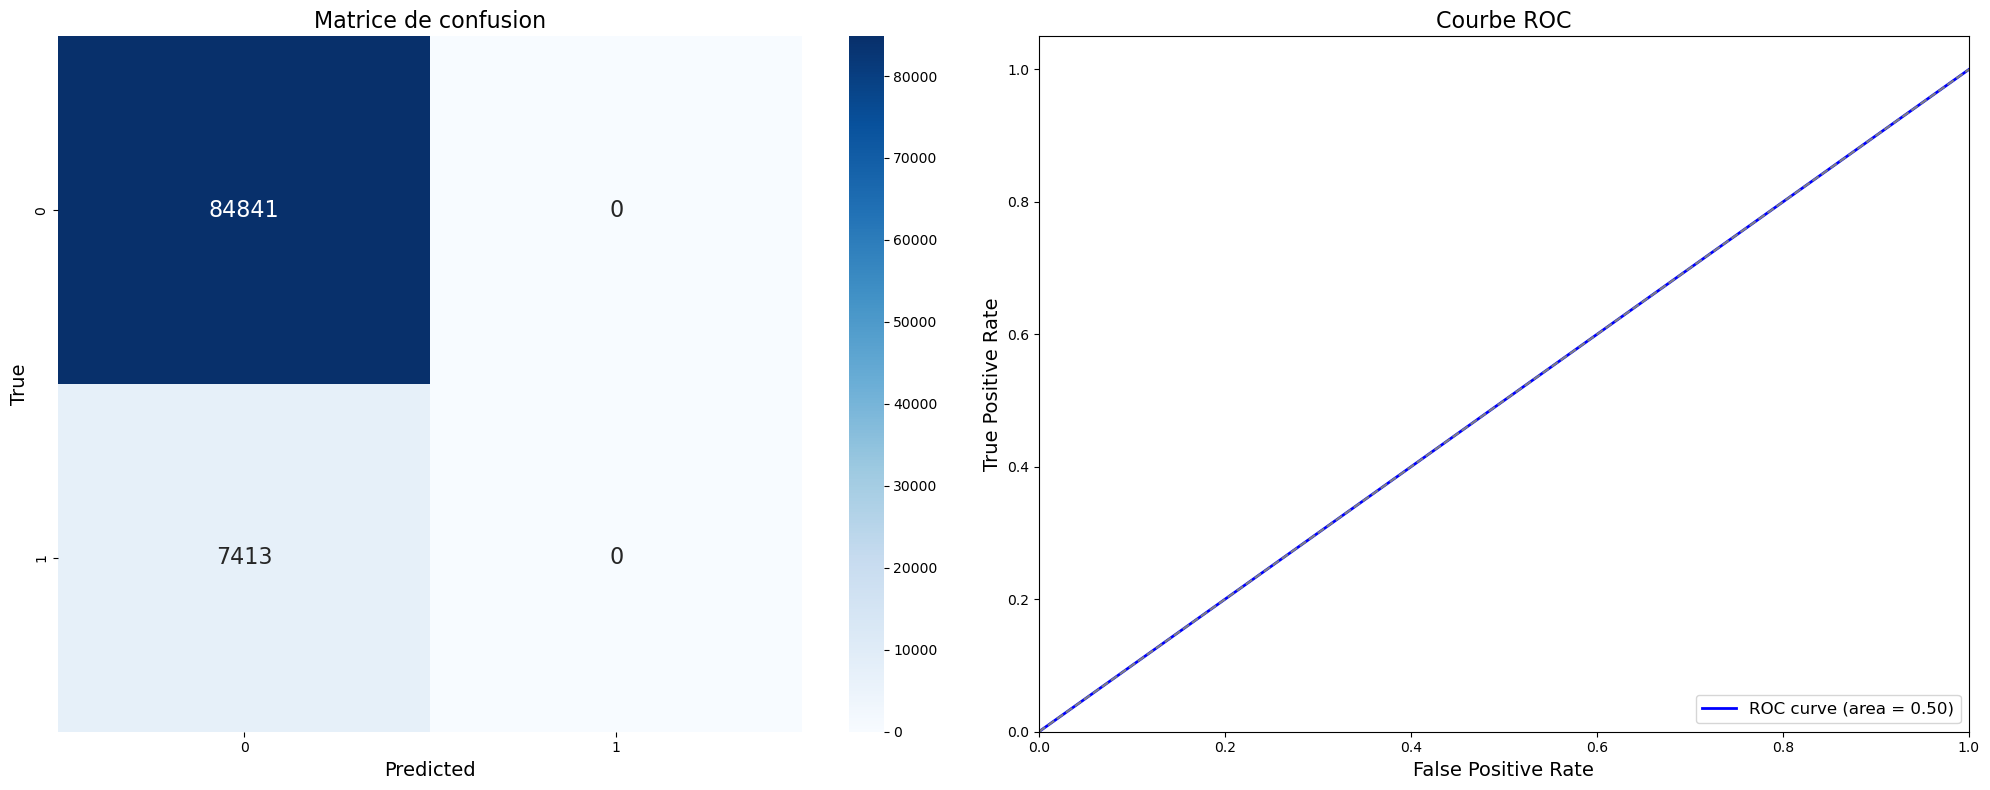

In [12]:
# Évaluer chaque modèle
for model_name, model in models.items():
    print(f"Évaluation du modèle: {model_name}")
    evaluate_model(model, X_train_split_smote, y_train_split_smote, X_val, y_val, model_name)

Les résultats que nousu obtenons pour le Dummy Classifier après avoir appliqué SMOTE montrent un écart important entre l'accuracy moyenne pendant l'entraînement et l'accuracy sur le jeu de test. 

1. **Accuracy élevée sur le jeu de test** :
   - L'accuracy suggère que le modèle prédit la classe majoritaire (negative) pour la quasi-totalité des échantillons du jeu de test. 
   - Cette accuracy élevée est trompeuse car le modèle ne capture aucune information utile, comme le montre la **matrice de confusion** : toutes les prédictions sont dans la classe "Predicted Negative".
   - **Pourquoi ?** Le Dummy Classifier avec SMOTE prédit probablement la classe majoritaire (ou aléatoirement), mais le jeu de test reste déséquilibré, donc la majorité des échantillons appartiennent à la classe majoritaire. C'est pourquoi il semble obtenir une bonne accuracy.

2. **Matrice de confusion** :
   - La matrice de confusion montre clairement que le Dummy Classifier ne prédit jamais la classe positive (aucune prédiction correcte pour les `True Positive`).
   - Cela confirme que le modèle est trivial et n’apporte aucune valeur dans ce contexte, malgré une bonne accuracy apparente.


Ces résultats confirment que **le Dummy Classifier ne tire pas profit du rééquilibrage SMOTE**, et bien que l'accuracy puisse sembler bonne sur le jeu de test, elle n’est pas un indicateur pertinent ici. Il est important de se concentrer sur d’autres métriques comme le **AUC-ROC** ou la **précision sur la classe minoritaire** pour mieux évaluer les modèles dans des situations de classes déséquilibrées.

# 3 - Premier modèle de prédiction

La régression logistique est un modèle statistique utilisé principalement pour des tâches de classification binaire. Contrairement à une régression linéaire qui prédit une valeur continue, la régression logistique prédit la probabilité qu'un échantillon appartienne à une classe donnée. En sortie, elle donne des probabilités comprises entre 0 et 1, qui peuvent être ensuite converties en classes (0 ou 1) en fonction d'un seuil.

En tant que premier modèle de base, la régression logistique nous permettra d'établir une baseline pour prédire la probabilité de défaut de paiement. En testant le modèle avant et après l'application de SMOTE, nous allons comparer l'impact du rééquilibrage des classes sur les performances du modèle.
L'application de SMOTE avant l'entraînement d'une régression logistique peut potentiellement améliorer les performances, notamment sur des données déséquilibrées, car elle crée de nouveaux échantillons dans la classe minoritaire.

## 3.1 - Régression logistique

In [13]:
# Définition du modèle de Régression Logistique
models = {
    'Régression Logistique': LogisticRegression(max_iter=1000)
}

# Initialisation d'un DataFrame pour stocker les résultats
results_df = pd.DataFrame(columns=['Model', 'AUC_mean', 'Accuracy_mean', 'Fit_time_mean', 'Score_time_mean'])

# Évaluation de chaque modèle avec cross_validate
for name, model in models.items():
    with mlflow.start_run(run_name=name):
        scores = cross_validate(model, X_train_split, y_train_split, cv=5, 
                                scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy'},
                                return_train_score=False, n_jobs=-1)
        
        # Calcul des moyennes
        auc_mean = np.mean(scores['test_AUC'])
        accuracy_mean = np.mean(scores['test_Accuracy'])
        fit_time_mean = np.mean(scores['fit_time'])
        score_time_mean = np.mean(scores['score_time'])

        # Logging dans MLFlow
        mlflow.log_param("Model", name)
        mlflow.log_metric("AUC", auc_mean)
        mlflow.log_metric("Accuracy", accuracy_mean)
        mlflow.log_metric("Fit_time", fit_time_mean)
        mlflow.log_metric("Score_time", score_time_mean)
        
        # Enregistrement du modèle dans MLFlow
        mlflow.sklearn.log_model(model, "model")
        
        # Stockage dans DataFrame des résultats
        new_row = pd.DataFrame({
            'Model': [name],
            'AUC_mean': [auc_mean],
            'Accuracy_mean': [accuracy_mean],
            'Fit_time_mean': [fit_time_mean],
            'Score_time_mean': [score_time_mean]
        })

        results_df = pd.concat([results_df, new_row], ignore_index=True)

# Affichage des résultats
print(results_df)

mlflow.end_run()

2024/09/13 14:53:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


                   Model  AUC_mean  Accuracy_mean  Fit_time_mean  \
0  Régression Logistique  0.757531       0.919236      21.104289   

   Score_time_mean  
0         0.067959  


Évaluation du modèle: Régression Logistique
Accuracy: 0.9202

Matrice de confusion (table) :
               Predicted Negative  Predicted Positive
True Negative               84730                 111
True Positive                7254                 159


2024/09/13 14:53:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


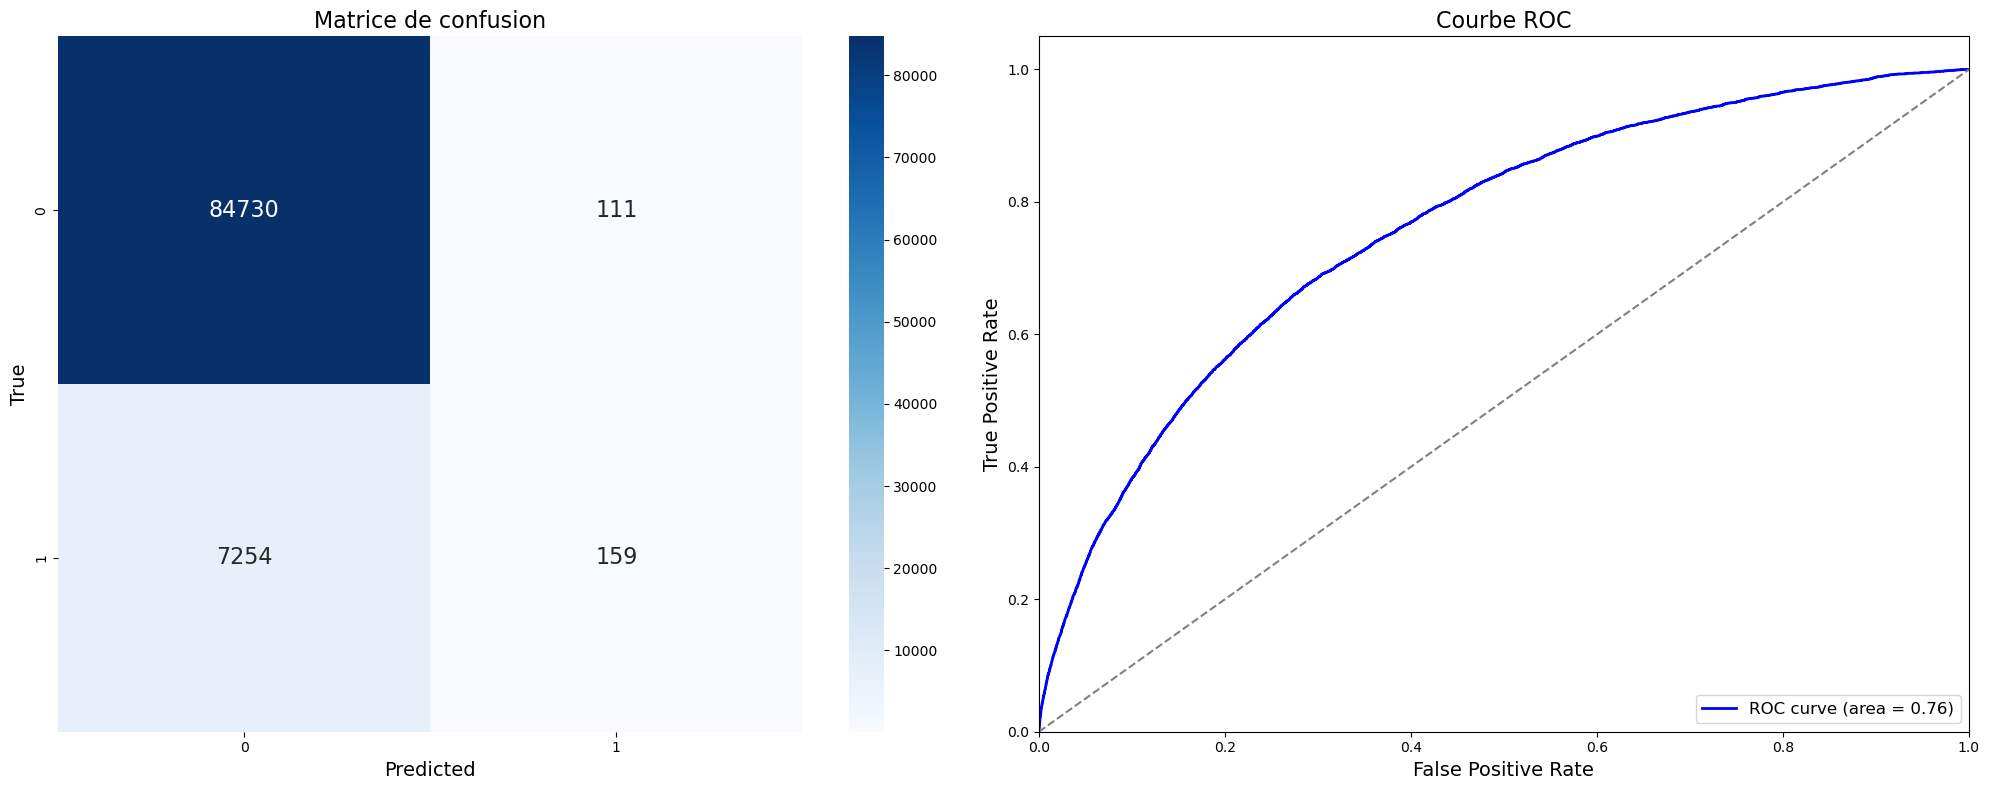

In [14]:
# Évaluer notre modèle sur le test_set
for model_name, model in models.items():
    print(f"Évaluation du modèle: {model_name}")
    evaluate_model(model, X_train_split, y_train_split, X_val, y_val, model_name)

Les résultats de la régression logistique avant l'application de SMOTE montrent des performances satisfaisantes mais trompeuses :

- **AUC_mean** : 0.75 — Cela signifie que le modèle parvient à différencier les classes positives et négatives avec une bonne précision.
- **Accuracy** : 92 % — Le modèle est capable de prédire correctement environ 92 % des exemples.
- **Matrice de confusion** :
  - **True Negative** : Le modèle prédit correctement que 84 730 échantillons n'appartiennent pas à la classe positive.
  - **True Positive** : Seulement 159 échantillons de la classe positive sont correctement prédits.
  - **False Negative** : Il y a un nombre significatif d'échantillons de la classe positive qui sont incorrectement classés comme négatifs.

Nous pouvons analyser cela de la manière suivante :
- **AUC** : le modèle parvient à bien capturer les relations dans les données, mais il pourrait encore être amélioré.
- **Matrice de confusion** : Le nombre élevé de faux négatifs par rapport au nombre relativement faible de vrais positifs est un signe que le modèle a du mal à identifier correctement la classe minoritaire (les défauts de paiement).

Après SMOTE, nous pourrons comparer ces résultats pour évaluer si le rééquilibrage des classes améliore la capacité du modèle à prédire la classe minoritaire. Il serait intéressant de voir si le nombre de vrais positifs augmente après SMOTE, tout en maintenant un bon compromis avec le nombre de faux positifs et la précision globale.

## 3.2 - Régression Logistique après SMOTE

In [15]:
# Définition du modèle de Régression Logistique
models = {
    'Régression Logistique (SMOTE)': LogisticRegression(max_iter=1000)
}

# Initialisation d'un DataFrame pour stocker les résultats
results_df_smote = pd.DataFrame(columns=['Model', 'AUC_mean', 'Accuracy_mean', 'Fit_time_mean', 'Score_time_mean'])

# Évaluation de chaque modèle avec cross_validate
for name, model in models.items():
    with mlflow.start_run(run_name=name):
        scores = cross_validate(model, X_train_split_smote, y_train_split_smote, cv=5, 
                                scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy'},
                                return_train_score=False, n_jobs=-1)
        
        # Calcul des moyennes
        auc_mean = np.mean(scores['test_AUC'])
        accuracy_mean = np.mean(scores['test_Accuracy'])
        fit_time_mean = np.mean(scores['fit_time'])
        score_time_mean = np.mean(scores['score_time'])

        # Logging dans MLFlow
        mlflow.log_param("Model", name)
        mlflow.log_metric("AUC", auc_mean)
        mlflow.log_metric("Accuracy", accuracy_mean)
        mlflow.log_metric("Fit_time", fit_time_mean)
        mlflow.log_metric("Score_time", score_time_mean)
        
        # Enregistrement du modèle dans MLFlow
        mlflow.sklearn.log_model(model, "model")
        
        # Stockage dans DataFrame des résultats
        new_row = pd.DataFrame({
            'Model': [name],
            'AUC_mean': [auc_mean],
            'Accuracy_mean': [accuracy_mean],
            'Fit_time_mean': [fit_time_mean],
            'Score_time_mean': [score_time_mean]
        })

        results_df_smote = pd.concat([results_df_smote, new_row], ignore_index=True)

# Affichage des résultats
print(results_df_smote)

mlflow.end_run()

2024/09/13 14:55:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


                           Model  AUC_mean  Accuracy_mean  Fit_time_mean  \
0  Régression Logistique (SMOTE)   0.79304       0.722626     117.476038   

   Score_time_mean  
0         0.204139  


Évaluation du modèle: Régression Logistique (SMOTE)
Accuracy: 0.7047

Matrice de confusion (table) :
               Predicted Negative  Predicted Positive
True Negative               60087               24754
True Positive                2486                4927


2024/09/13 14:56:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


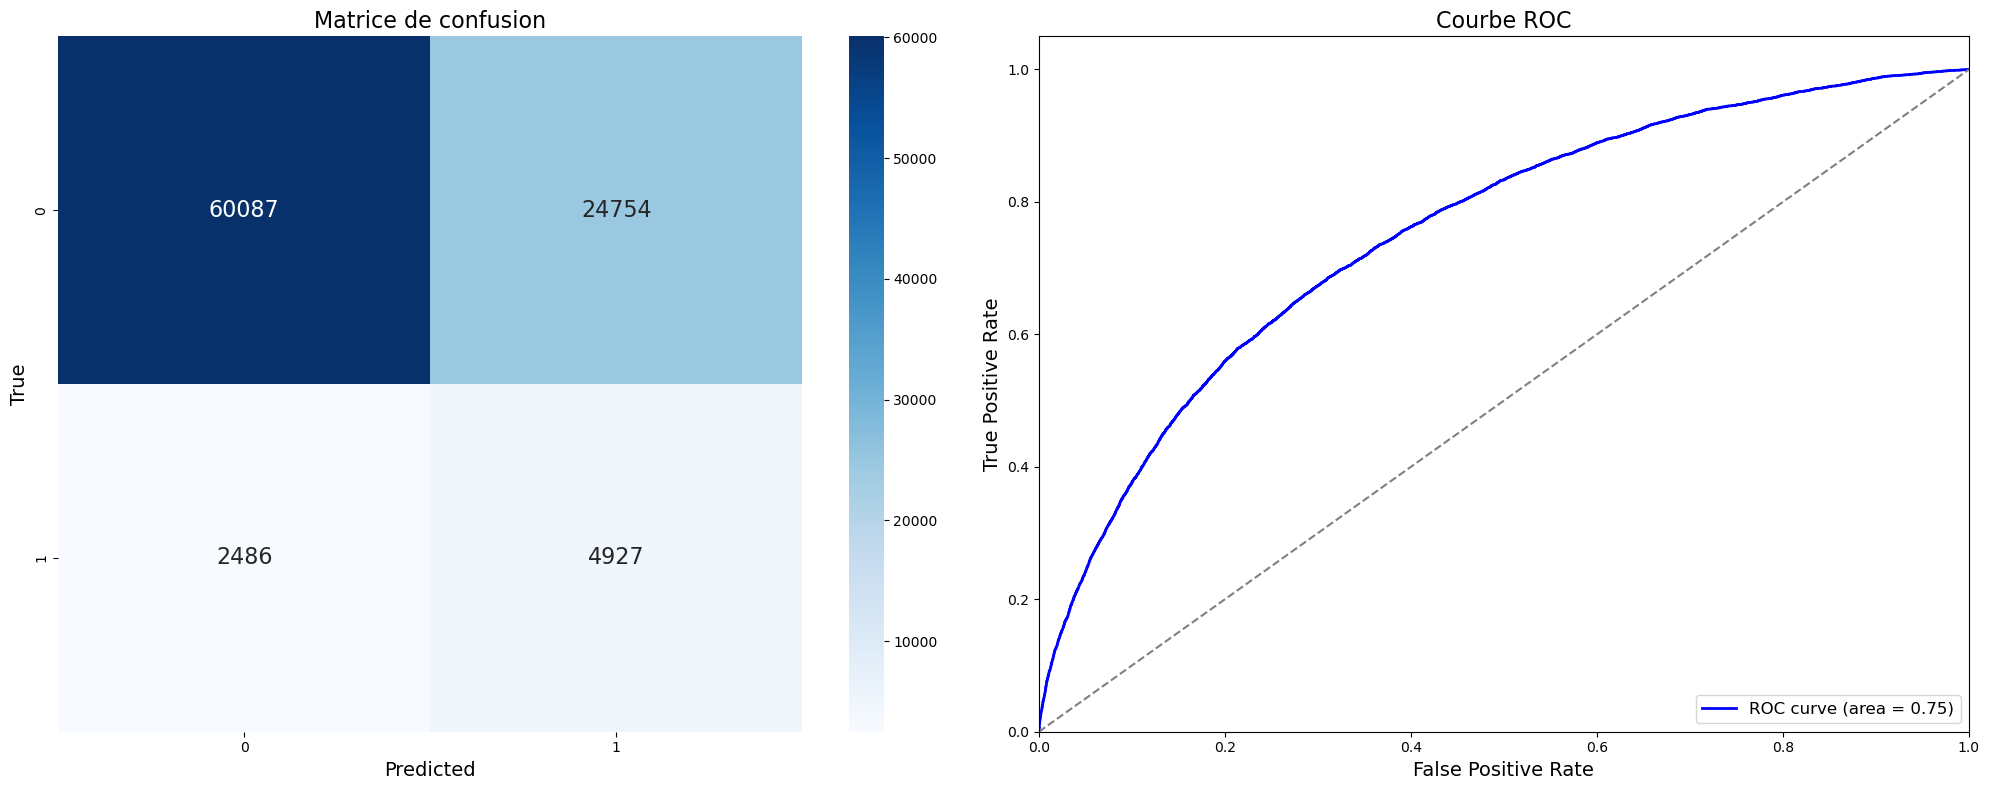

In [16]:
# Évaluer chaque modèle
for model_name, model in models.items():
    print(f"Évaluation du modèle: {model_name}")
    evaluate_model(model, X_train_split_smote, y_train_split_smote, X_val, y_val, model_name)

Les résultats après l'application de SMOTE montrent un impact important sur les performances de la régression logistique. 

- **AUC_mean** : 0.79 — L'AUC a augmenté, ce qui indique que le modèle parvient mieux à différencier les classes positives et négatives après le rééquilibrage des classes avec SMOTE.
- **Accuracy** : 72 % — L'accuracy a diminué par rapport à avant SMOTE, mais cela est attendu, car SMOTE a ajouté des échantillons synthétiques de la classe minoritaire, ce qui rend le problème plus difficile pour le modèle.
- **Matrice de confusion** :
  - **True Negative** : Le modèle prédit correctement 60 087 échantillons négatifs.
  - **True Positive** : Le nombre de vrais positifs a considérablement augmenté, avec 4 927 échantillons correctement prédits.
  - **False Negative** : Le nombre de faux négatifs a diminué.
  - **False Positive** : Le nombre de faux positifs a fortement augmenté, ce qui contribue à la baisse de l'accuracy.

Nous pouvons analyser cela :
- **Amélioration de l'AUC** : ce qui signifie que le modèle a amélioré sa capacité à distinguer les classes après SMOTE.
- **Diminution de l'accuracy** : car le modèle fait plus d'erreurs en classant certains exemples de la classe majoritaire comme appartenant à la classe minoritaire (faux positifs). Cela est souvent un compromis après SMOTE, car l'objectif est de mieux capturer la classe minoritaire.
- **Matrice de confusion** : L'augmentation significative des vrais positifs montre que le modèle est désormais bien meilleur pour prédire la classe minoritaire (défaut de paiement). Cependant, cela a coûté un nombre important de faux positifs.

Après SMOTE, le modèle est plus équilibré en termes de prédiction de la classe minoritaire, comme le montre l'augmentation des vrais positifs et l'amélioration de l'AUC. Cependant, cela s'est fait au détriment de l'accuracy, car le modèle génère beaucoup plus de faux positifs. En fonction des objectifs métier (minimiser les faux négatifs ou faux positifs), il sera important d'ajuster le modèle ou de tester d'autres techniques comme l'ajustement des seuils de décision.

# 4 - Deuxième modèle de prédiction

Nous allons maintenant implémenter et comparer les performances de deux modèles de gradient boosting, avant et après l'application de SMOTE.

In [17]:
# Nettoyage des noms de colonnes en supprimant les caractères spéciaux
X_train_split.columns = X_train_split.columns.str.replace(r'[^\w]', '_', regex=True)
X_train_split_smote.columns = X_train_split_smote.columns.str.replace(r'[^\w]', '_', regex=True)
X_val.columns = X_val.columns.str.replace(r'[^\w]', '_', regex=True)

## 4.1 - Gradient Boosting

Le **Gradient Boosting** est une technique de machine learning supervisée utilisée principalement pour les tâches de classification et de régression. Il repose sur l'idée de combiner plusieurs modèles simples (généralement des arbres de décision) pour former un modèle plus performant. Le principe clé du Gradient Boosting est de construire ces modèles séquentiellement, où chaque modèle essaie de corriger les erreurs commises par les modèles précédents. 

Le modèle final est donc une combinaison pondérée de ces modèles faibles, où les modèles successifs "boostent" les performances des précédents en se concentrant sur les observations mal prédictes.

Le **Gradient Boosting** peut être coûteux en termes de calcul et de temps d'entraînement, car il construit les arbres de manière séquentielle. Pour répondre à ce problème, deux algorithmes populaires, **XGBoost** et **LGBM**, ont été développés pour optimiser cette approche.

1. **XGBoost (Extreme Gradient Boosting)**

**XGBoost** est une implémentation optimisée de l'algorithme de Gradient Boosting qui est particulièrement efficace pour les grandes bases de données. Il se distingue par sa rapidité et son efficacité, grâce à plusieurs optimisations importantes :
- **Traitement parallèle** : Contrairement au Gradient Boosting classique qui construit les arbres séquentiellement, XGBoost permet d'entraîner les arbres en parallèle, ce qui réduit considérablement le temps d'exécution.
- **Régularisation** : XGBoost intègre des termes de régularisation (L1 et L2) pour éviter le surapprentissage, en forçant le modèle à être plus simple.
- **Gestion des valeurs manquantes** : XGBoost gère naturellement les données manquantes en apprenant des chemins optimaux pour les valeurs manquantes dans les arbres de décision.


2. **LGBM (LightGBM)**

**LightGBM** est une autre implémentation optimisée du Gradient Boosting, développée par Microsoft. **LGBM** se distingue par sa capacité à traiter de très grands volumes de données de manière encore plus rapide que XGBoost grâce à une approche de construction d'arbres appelée **Leaf-wise Tree Growth** :
- **Growth Leaf-Wise** : Contrairement à XGBoost qui ajoute des niveaux à chaque arbre (Level-wise), LGBM choisit d'ajouter des feuilles uniquement aux branches qui réduisent le plus l'erreur. Cela permet d'obtenir des arbres plus profonds et plus efficaces sans augmenter significativement le coût de calcul.
- **Gestion des grandes bases de données** : LGBM est particulièrement efficace pour des datasets volumineux ou très dimensionnels.
- **Optimisation de la mémoire** : LGBM a été conçu pour être plus économe en mémoire que XGBoost, ce qui est un avantage pour des tâches de grande échelle.

In [18]:
# Définition des modèles
models = {
    'LGBM Classifier': lgb.LGBMClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42)
}

# Initialisation d'un DataFrame pour stocker les résultats
results_df_lgbm = pd.DataFrame(columns=['Model', 'AUC_mean', 'Accuracy_mean', 'Fit_time_mean', 'Score_time_mean'])

# Évaluation de chaque modèle avec cross_validate
for name, model in models.items():
    with mlflow.start_run(run_name=name):
        scores = cross_validate(model, X_train_split, y_train_split, cv=5, 
                                scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy'},
                                return_train_score=False, n_jobs=-1)
        
        # Calcul des moyennes
        auc_mean = np.mean(scores['test_AUC'])
        accuracy_mean = np.mean(scores['test_Accuracy'])
        fit_time_mean = np.mean(scores['fit_time'])
        score_time_mean = np.mean(scores['score_time'])

        # Logging dans MLFlow
        mlflow.log_param("Model", name)
        mlflow.log_metric("AUC", auc_mean)
        mlflow.log_metric("Accuracy", accuracy_mean)
        mlflow.log_metric("Fit_time", fit_time_mean)
        mlflow.log_metric("Score_time", score_time_mean)
        
        # Enregistrement du modèle dans MLFlow
        mlflow.sklearn.log_model(model, "model")
        
        # Stockage des résultats dans DataFrame
        new_row = pd.DataFrame({
            'Model': [name],
            'AUC_mean': [auc_mean],
            'Accuracy_mean': [accuracy_mean],
            'Fit_time_mean': [fit_time_mean],
            'Score_time_mean': [score_time_mean]
        })

        results_df_lgbm = pd.concat([results_df_lgbm, new_row], ignore_index=True)

# Affichage des résultats
print(results_df_lgbm)

mlflow.end_run()

2024/09/13 14:56:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/13 14:57:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


             Model  AUC_mean  Accuracy_mean  Fit_time_mean  Score_time_mean
0  LGBM Classifier  0.773101       0.919454       8.980978         0.182039
1          XGBoost  0.764229       0.917986      13.121610         0.414559


Voici une analyse rapide des résultats obtenus avant l'application de **SMOTE** pour les deux modèles **LGBM Classifier** et **XGBoost** :

**LGBM Classifier :**
- **AUC_mean** : 0.7731 – Un score AUC qui montre une bonne capacité de discrimination. Cela indique que le modèle parvient à bien différencier entre les classes positives (clients en défaut) et négatives (clients non en défaut).
- **Accuracy_mean** : 0.9195 – Le modèle atteint une très bonne précision, ce qui reflète la proportion de prédictions correctes.
- **Fit_time_mean** : 8.98 secondes – L'entraînement du modèle est assez rapide.
- **Score_time_mean** : 0.1820 seconde – Le temps pour réaliser les prédictions est également très court, ce qui est un atout pour les systèmes de scoring en temps réel.

**XGBoost :**
- **AUC_mean** : 0.7642 – Légèrement inférieur à celui de LGBM, mais reste un score solide qui montre une bonne capacité de discrimination.
- **Accuracy_mean** : 0.9180 – Un peu plus bas que LGBM, mais reste très élevé et performant.
- **Fit_time_mean** : 13.12 secondes – L'entraînement de XGBoost est un peu plus long que celui de LGBM, ce qui est habituel étant donné l'approche plus intensive de XGBoost.
- **Score_time_mean** : 0.4146 seconde – Le temps de prédiction est environ deux fois plus long que LGBM, mais reste raisonnable pour des systèmes de production.

**Comparaison globale :**
- **Performance** : LGBM affiche de meilleures performances en termes de score AUC et de précision, bien que les deux modèles soient assez proches.
- **Temps d'exécution** : LGBM est plus rapide à l'entraînement et pour la prédiction, ce qui peut en faire un candidat plus efficace dans des contextes où la rapidité est cruciale.

Évaluation du modèle: LGBM Classifier
[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35623
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 332
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score -2.430324
Accuracy: 0.9202

Matrice de confusion (table) :
               Predicted Negative  Predicted Positive
True Negative               84651                 190
True Positive                7172                 241


2024/09/13 14:57:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


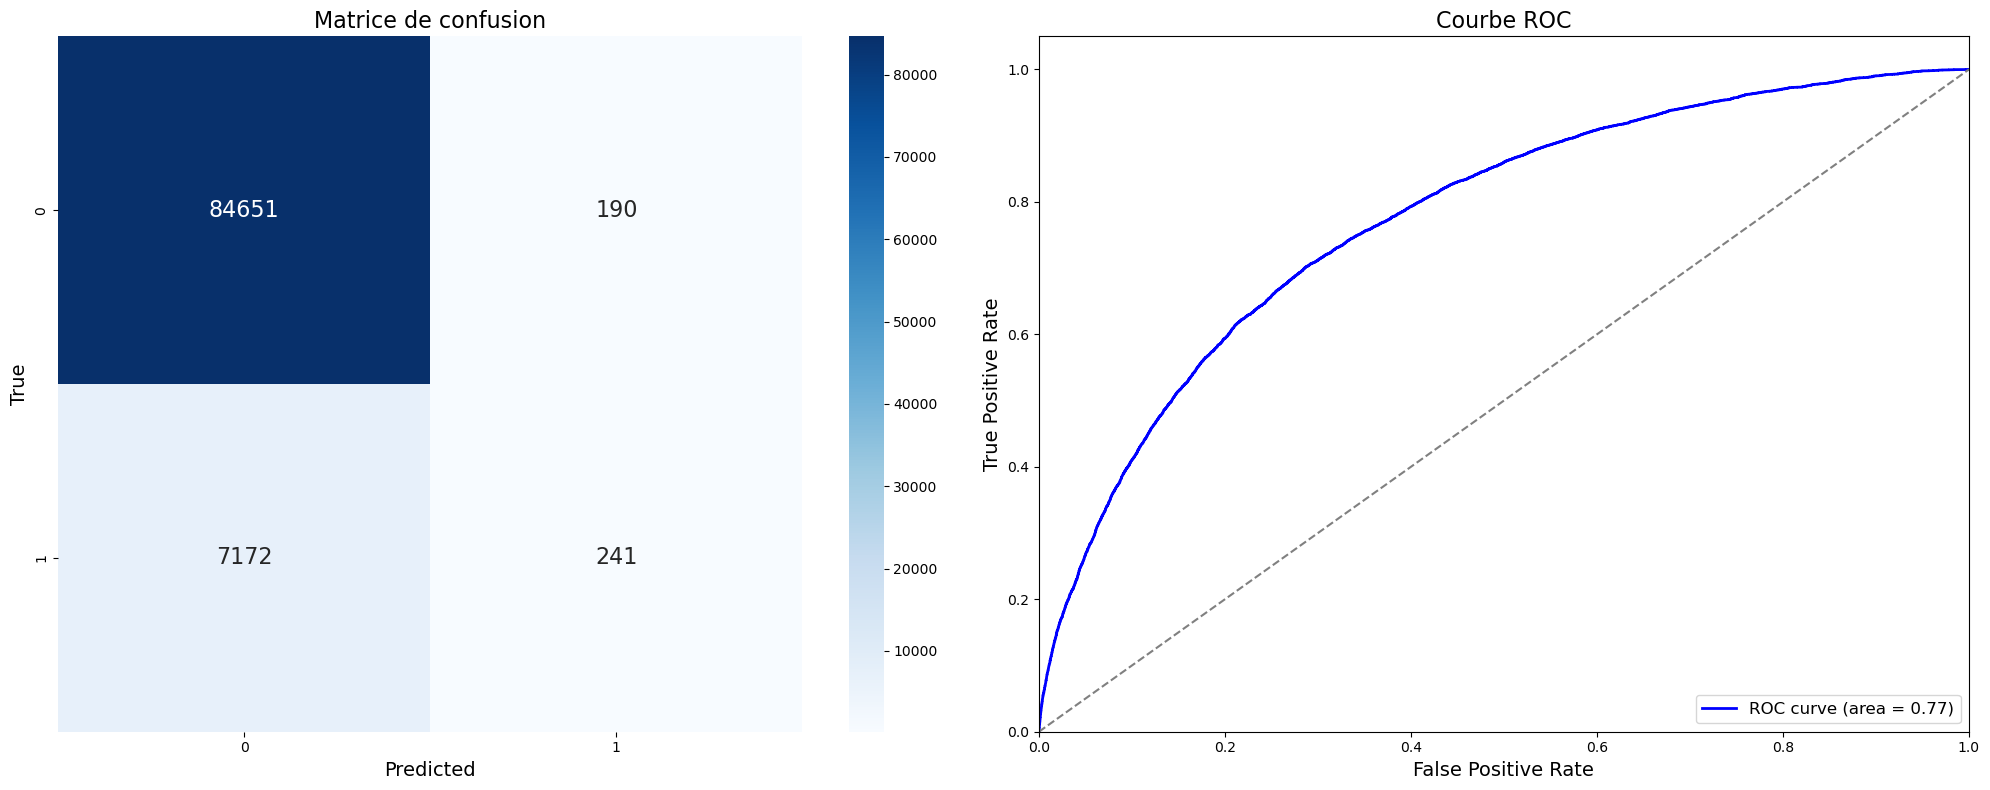

Évaluation du modèle: XGBoost
Accuracy: 0.9191

Matrice de confusion (table) :
               Predicted Negative  Predicted Positive
True Negative               84364                 477
True Positive                6989                 424


2024/09/13 14:57:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


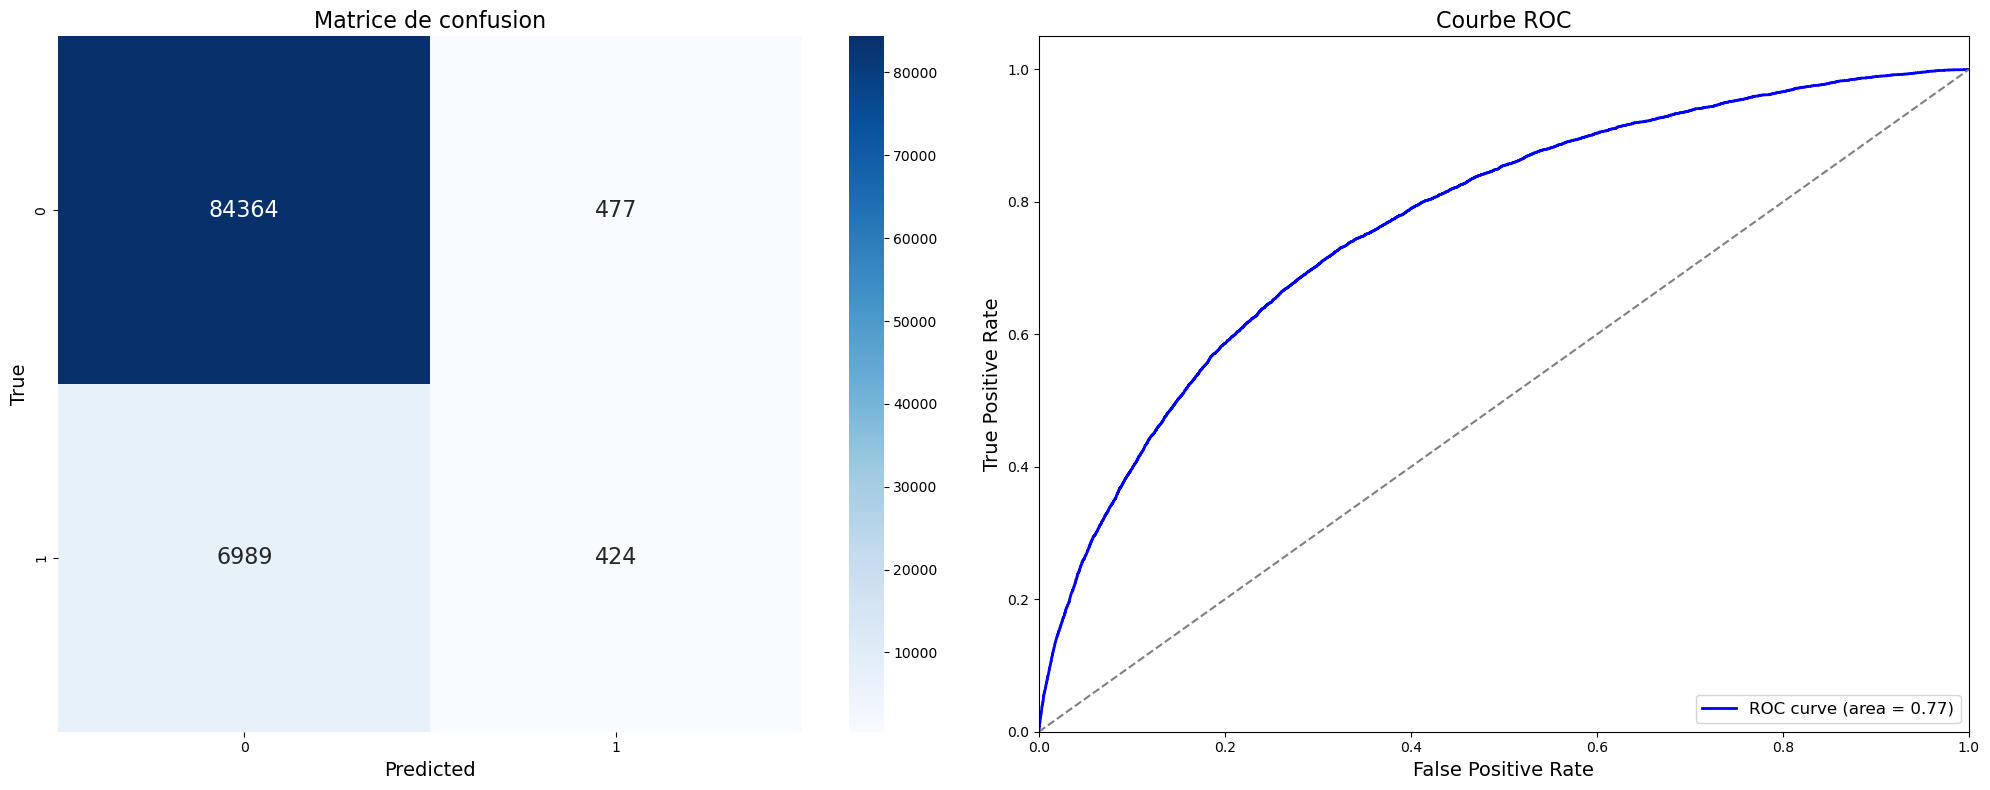

In [19]:
# Évaluer chaque modèle
for model_name, model in models.items():
    print(f"Évaluation du modèle: {model_name}")
    evaluate_model(model, X_train_split, y_train_split, X_val, y_val, model_name)

## 4.2 - Gradient Boosting après SMOTE

In [20]:
# Définition des modèles
models = {
    'LGBM Classifier (SMOTE': lgb.LGBMClassifier(random_state=42),
    'XGBoost (SMOTE)': xgb.XGBClassifier(random_state=42)
    }

# Initialisation d'un DataFrame pour stocker les résultats
results_df = pd.DataFrame(columns=['Model', 'AUC_mean', 'Accuracy_mean', 'Fit_time_mean', 'Score_time_mean'])

# Évaluation de chaque modèle
for name, model in models.items():
    with mlflow.start_run(run_name=name):
        # Cross-validation sur chaque modèle
        scores = cross_validate(model, X_train_split_smote, y_train_split_smote, cv=5, 
                                scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy'},
                                return_train_score=False, n_jobs=-1)
        
        # Calcul des moyennes
        auc_mean = np.mean(scores['test_AUC'])
        accuracy_mean = np.mean(scores['test_Accuracy'])
        fit_time_mean = np.mean(scores['fit_time'])
        score_time_mean = np.mean(scores['score_time'])

        # Logging dans MLFlow
        mlflow.log_param("Model", name)
        mlflow.log_metric("AUC", auc_mean)
        mlflow.log_metric("Accuracy", accuracy_mean)
        mlflow.log_metric("Fit_time", fit_time_mean)
        mlflow.log_metric("Score_time", score_time_mean)
        
        # Enregistrement du modèle dans MLFlow
        mlflow.sklearn.log_model(model, "model")
        
        # Stockage dans DataFrame des résultats
        new_row = pd.DataFrame({
            'Model': [name],
            'AUC_mean': [auc_mean],
            'Accuracy_mean': [accuracy_mean],
            'Fit_time_mean': [fit_time_mean],
            'Score_time_mean': [score_time_mean]
        })

        results_df = pd.concat([results_df, new_row], ignore_index=True)

# Affichage des résultats
print(results_df)

mlflow.end_run()

2024/09/13 14:57:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/13 14:58:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


                    Model  AUC_mean  Accuracy_mean  Fit_time_mean  \
0  LGBM Classifier (SMOTE  0.968983       0.953640      27.399135   
1         XGBoost (SMOTE)  0.970721       0.950896      37.223703   

   Score_time_mean  
0         0.811649  
1         0.728683  


Il faut bien analyser tout cela. Malgré le fait que l'accuracy soit élevé, la majorité des prédictions sont que le clients na va pas faire défaut (puisque c'est la classe la plus représenté l'algo à moins de chance de se tromper), cepedant cela peut avoir de grave conséquence pour la banque si la prédiction est fausse. D'ou la nécessité de constuire un score métier avec des pondérations.

Évaluation du modèle: LGBM Classifier (SMOTE
[LightGBM] [Info] Number of positive: 197845, number of negative: 197845
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 75598
[LightGBM] [Info] Number of data points in the train set: 395690, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.9193

Matrice de confusion (table) :
               Predicted Negative  Predicted Positive
True Negative               84677                 164
True Positive                7285                 128


2024/09/13 14:58:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


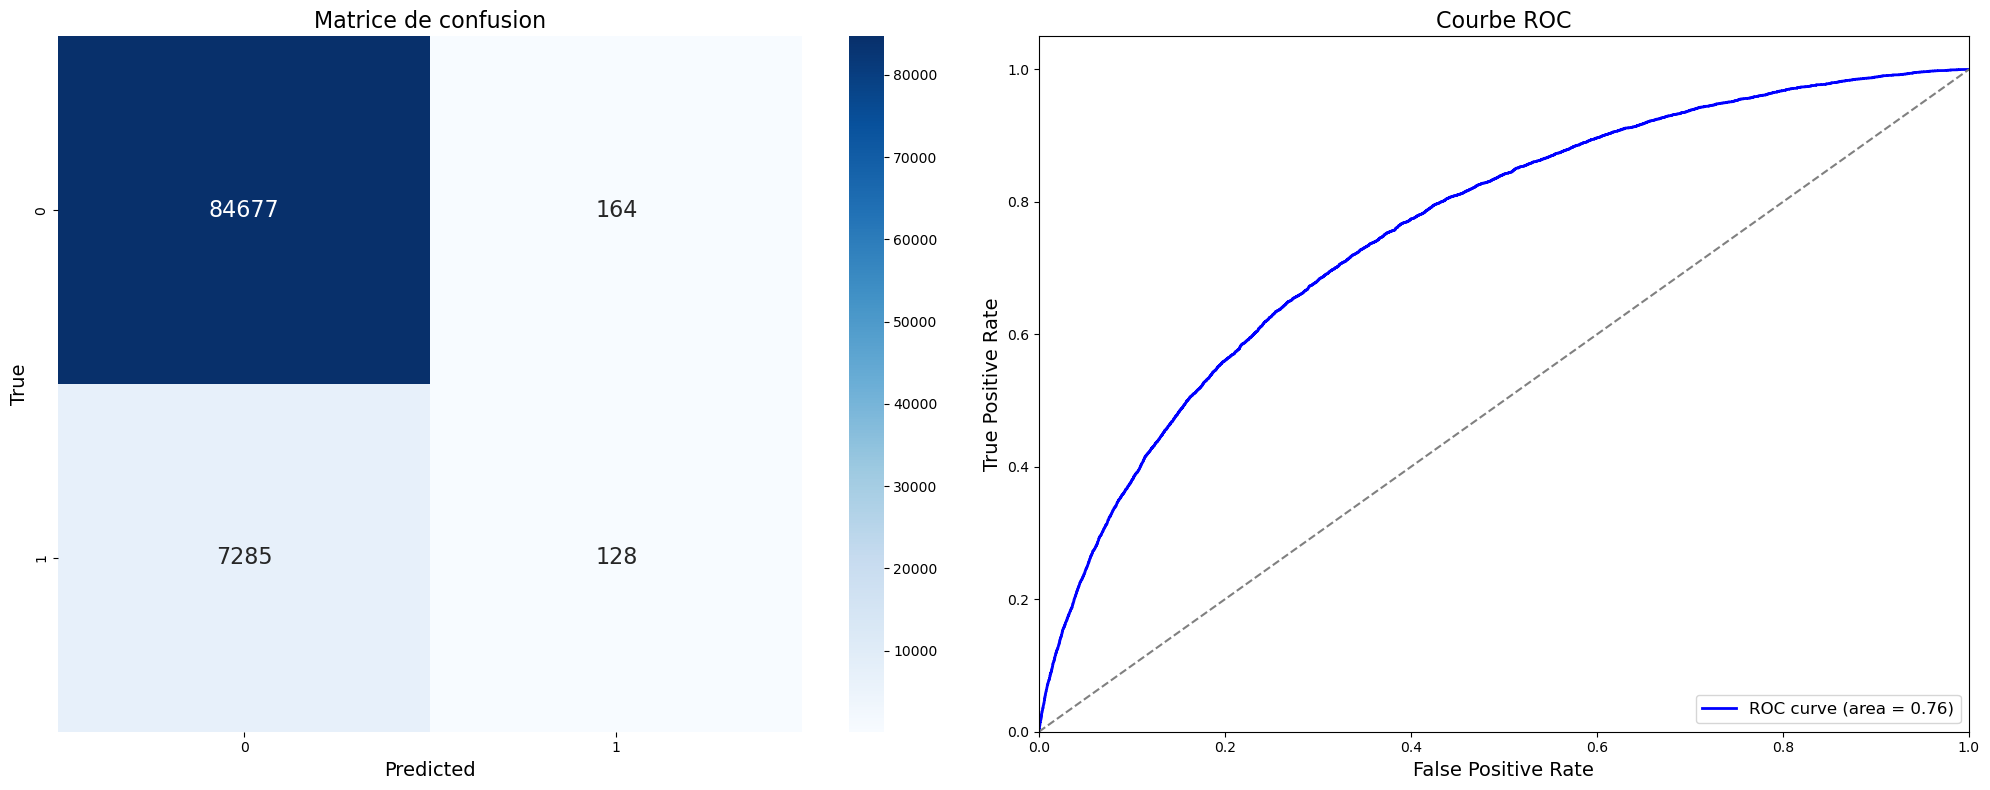

Évaluation du modèle: XGBoost (SMOTE)
Accuracy: 0.9182

Matrice de confusion (table) :
               Predicted Negative  Predicted Positive
True Negative               84274                 567
True Positive                6977                 436


2024/09/13 14:58:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


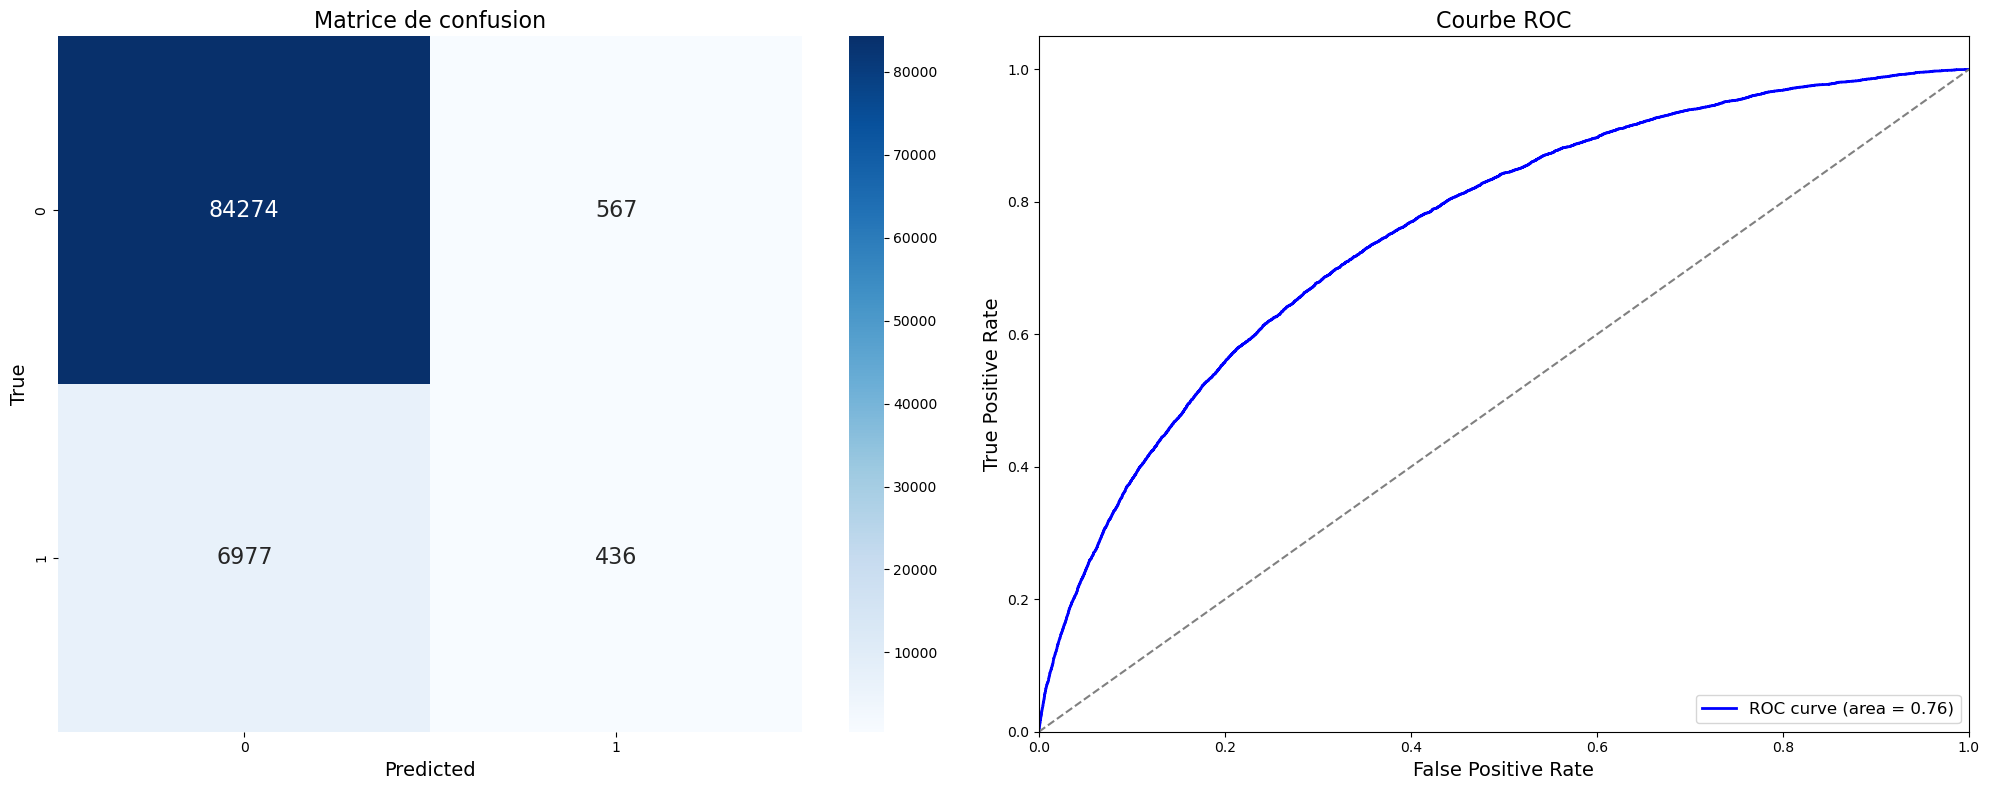

In [21]:
# Évaluer chaque modèle
for model_name, model in models.items():
    print(f"Évaluation du modèle: {model_name}")
    evaluate_model(model, X_train_split_smote, y_train_split_smote, X_val, y_val, model_name)

Analyse des résultats et petite conclusion avant de passer à la Features selection.

# 5 - Features selection

In [22]:
elapsed_time = time.time() - start  # Calcule le temps écoulé
print(f"Temps total d'exécution du notebook : {elapsed_time:.2f} secondes.")

Temps total d'exécution du notebook : 384.85 secondes.
